In [2]:
import pandas as pd
import networkx as nx

In [3]:
edges = pd.read_csv('/Users/geyuanyuan1/Downloads/gameofthrones-master/data/got-s1-edges.csv')

In [4]:
# nodes = pd.read_csv('/Users/geyuanyuan1/Downloads/gameofthrones-master/data/got-s1-nodes.csv')

In [5]:
edges

,Source,Target,Weight,Season
0,NED,ROBERT,192,1
1,DAENERYS,JORAH,154,1
2,JON,SAM,121,1
3,LITTLEFINGER,NED,107,1
4,NED,VARYS,96,1
...,...,...,...,...
544,SANSA,STANNIS,2,1
545,STANNIS,TOMARD,2,1
546,THEON,WILL,2,1
547,TYRION,TYSHA,2,1


In [6]:
G = nx.DiGraph() 

In [7]:
G = nx.from_pandas_edgelist(edges,source='Source',target='Target',edge_attr=True)

In [9]:
import seaborn as sns


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


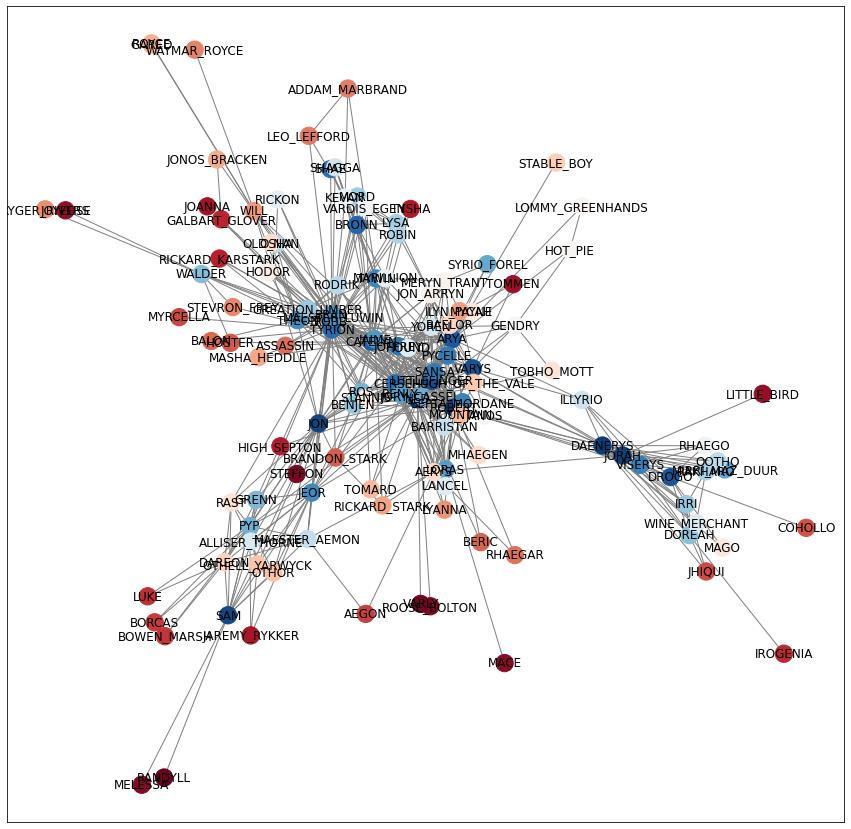

In [19]:
import matplotlib.pyplot as plt
import community.community_louvain

comm = community.community_louvain.best_partition(G)

layout = nx.spring_layout(G,0.01)
fig = plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=layout,node_color = sns.color_palette(
        "RdBu_r", len(comm)),edge_color = 'grey')

In [166]:
G = nx.from_pandas_edgelist(edges,source='Source',target='Target',edge_attr=True)
comm = community.community_louvain.best_partition(G)


In [203]:
import random
def getRandomPointInCircle(num, radius, centerx, centery):
    samplePoint = []
    for i in range(num):
        while True:
            x = random.uniform(-radius, radius)
            y = random.uniform(-radius, radius)
            if (x ** 2) + (y ** 2) <= (radius ** 2):
                if (x != 0) & (y!=0):
                    samplePoint.append((x + centerx, y + centery))
                    break

#         plt.plot(x + centerx, y + centery, '*', color="blue")

    return samplePoint


In [205]:
comm_df = pd.DataFrame(comm.items())
comm_df = comm_df.merge(pd.DataFrame(nx.pagerank(G).items()),on=0)
comm_df.columns = ['node','community','pagerank']
comm_df['rank'] = comm_df.groupby(['community'])['pagerank'].rank(ascending=False,method='dense')

In [206]:
center_df = edges.merge(comm_df,left_on ='Source' ,right_on ='node')\
.merge(comm_df,left_on = 'Target',right_on = 'node',suffixes = ['_1','_2'] )
center_df = center_df[(center_df['rank_1']==1)&(center_df['rank_2']==1)]

In [207]:
center_df

,Source,Target,Weight,Season,node_1,community_1,pagerank_1,rank_1,node_2,community_2,pagerank_2,rank_2
90,NED,ROBB,23,1,NED,4,0.047324,1.0,ROBB,3,0.024265,1.0
91,JON,ROBB,25,1,JON,2,0.021047,1.0,ROBB,3,0.024265,1.0
143,NED,TYRION,11,1,NED,4,0.047324,1.0,TYRION,5,0.034297,1.0
144,JON,TYRION,45,1,JON,2,0.021047,1.0,TYRION,5,0.034297,1.0
153,ROBB,TYRION,16,1,ROBB,3,0.024265,1.0,TYRION,5,0.034297,1.0
311,DAENERYS,NED,3,1,DAENERYS,1,0.017125,1.0,NED,4,0.047324,1.0
312,JON,NED,29,1,JON,2,0.021047,1.0,NED,4,0.047324,1.0
335,AERYS,NED,8,1,AERYS,0,0.011379,1.0,NED,4,0.047324,1.0


In [208]:
G_center = nx.from_pandas_edgelist(center_df,source='Source',target='Target',edge_attr=True)

In [209]:
pos_center = nx.spring_layout(G_center)

In [277]:
calculated_pos = {}
calculated_pos.update(pos_center)
for c in comm_df['community'].unique().tolist():
    sub_comm = comm_df[(comm_df['community']==c)&(comm_df['rank']>1)]
    center_node = comm_df[(comm_df['community']==c)&(comm_df['rank']==1)]['node'].tolist()[0]
    num = sub_comm['node'].nunique()
    radius = num/100+0.15
    centerx = pos_center[center_node][0]
    centery = pos_center[center_node][1]
    calculated_pos.update(dict(zip(sub_comm['node'].tolist(),getRandomPointInCircle(num, radius, centerx, centery))))

    
comm_df['color'] = comm_df['community'].map(dict(zip([i for i in range(comm_df['community'].nunique())],
              sns.color_palette( "RdBu",comm_df['community'].nunique()))))

node_size = [i*15000 for i in pd.DataFrame(G.nodes()).merge(pd.DataFrame(nx.pagerank(G).items()),on=0)[1].tolist()]  
node_color = pd.DataFrame(G.nodes()).merge(comm_df, left_on=0,right_on='node')['color'].tolist()



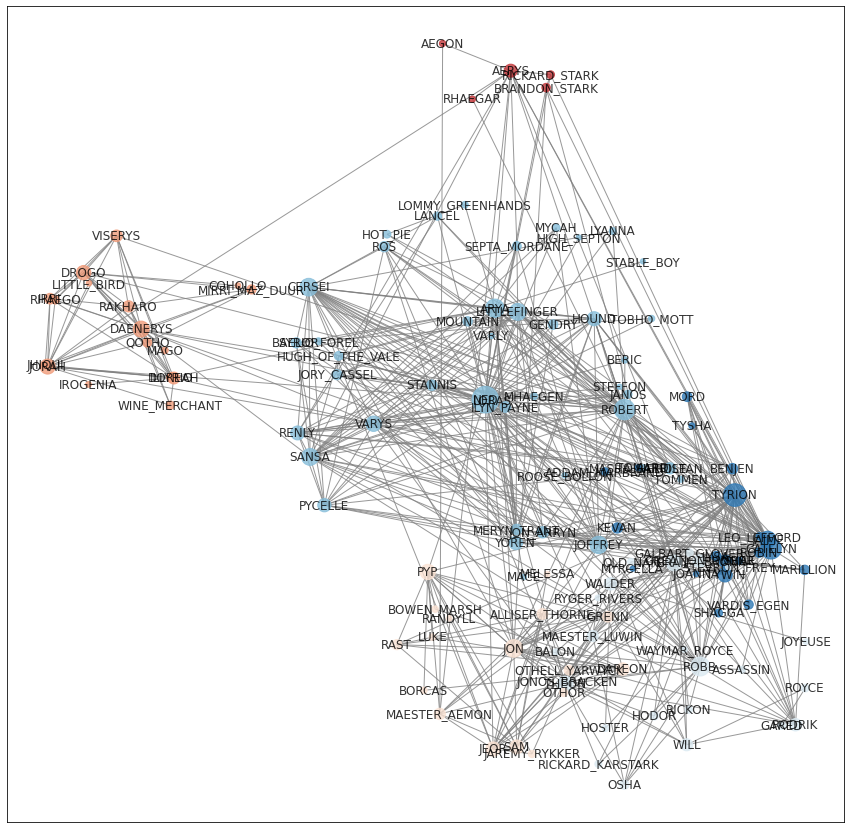

In [278]:
fig = plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=calculated_pos
                 ,node_color = node_color
                 ,edge_color = 'grey'
                 ,node_size = node_size
                 ,alpha=0.8)